<a href="https://colab.research.google.com/github/tianwainanfeng/gpu-data-stream-demo/blob/main/gpu_data_stream_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Show the GPU available in this Colab session
!nvidia-smi

Wed Oct 15 00:07:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Try 12.x wheel first (change to cupy-cuda11x if the install fails)
!pip install -q cupy-cuda12x numpy matplotlib

In [3]:
# Verify CuPy works and get device info
import importlib, sys
try:
    import cupy as cp
    print("CuPy version:", cp.__version__)
    print("Detected GPU name:", cp.cuda.runtime.getDeviceProperties(0)['name'].decode())
except Exception as e:
    print("CuPy import failed or no GPU available:", e)
    # fallback to numpy so the rest of the notebook still runs
    import numpy as cp
    print("Falling back to numpy. You won't get GPU acceleration.")


CuPy version: 13.3.0
Detected GPU name: Tesla T4


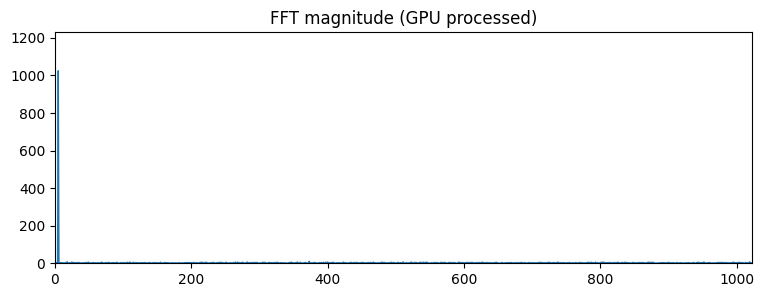

Demo finished.


In [4]:
# Real-time GPU/CPU data stream demo (notebook friendly)
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Try to use CuPy (GPU); fall back to NumPy (CPU)
USE_GPU = False
try:
    import cupy as cp
    USE_GPU = True
except Exception:
    import numpy as cp  # alias cp -> numpy for fallback

print("Running on", "GPU (CuPy)" if USE_GPU else "CPU (NumPy)")

STREAM_RATE_HZ = 20
CHUNK_SIZE = 2048
GPU_FILTER_ALPHA = 0.9
SHOW_FFT = True
DURATION_SEC = 10

start_time = time.time()
plt.ioff()

while time.time() - start_time < DURATION_SEC:
    # (1) Simulate data on CPU (numpy)
    t = np.linspace(0, 1, CHUNK_SIZE)
    noise = np.random.normal(0, 0.3, CHUNK_SIZE)
    signal = np.sin(2 * np.pi * 5 * t) + noise

    # (2) Move to GPU array if CuPy is used (cp may be numpy or cupy)
    gpu_data = cp.asarray(signal, dtype=cp.float32)

    # (3) Simple EMA filter (works with CuPy or NumPy)
    if 'prev' not in globals():
        prev = cp.zeros_like(gpu_data)
    gpu_filtered = GPU_FILTER_ALPHA * prev + (1 - GPU_FILTER_ALPHA) * gpu_data
    prev = gpu_filtered  # save state

    # (4) FFT optionally (on GPU if available)
    if SHOW_FFT:
        gpu_fft = cp.fft.fft(gpu_filtered)
        out = cp.asnumpy(cp.abs(gpu_fft[:CHUNK_SIZE // 2])) if USE_GPU else np.abs(gpu_fft[:CHUNK_SIZE // 2])
        x = np.arange(len(out))
        ylim = (0, out.max() * 1.2 + 1e-6)
        title = "FFT magnitude (GPU processed)" if USE_GPU else "FFT magnitude (CPU processed)"
    else:
        out = cp.asnumpy(gpu_filtered) if USE_GPU else np.asarray(gpu_filtered)
        x = np.arange(len(out))
        ylim = (-2, 2)
        title = "Filtered waveform (GPU)" if USE_GPU else "Filtered waveform (CPU)"

    # (5) Plot (clear & re-draw)
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(9,3))
    ax.plot(x, out, lw=1)
    ax.set_title(title)
    ax.set_xlim(0, x[-1])
    ax.set_ylim(*ylim)
    display(fig)
    plt.close(fig)

    # pace the stream
    time.sleep(1.0 / STREAM_RATE_HZ)

print("Demo finished.")